Notes are from Fandango, Armando. Mastering TensorFlow 1.x: Advanced machine learning and deep learning concepts using TensorFlow 1.x and Keras (Kindle Locations 1595-1597). Packt Publishing. Kindle Edition. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Generated-Datasets" data-toc-modified-id="Generated-Datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generated Datasets</a></span></li><li><span><a href="#Boston-Dataset" data-toc-modified-id="Boston-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Boston Dataset</a></span></li><li><span><a href="#Simple-Multi-Regression" data-toc-modified-id="Simple-Multi-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple Multi Regression</a></span></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Lasso-Regularlization" data-toc-modified-id="Lasso-Regularlization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Lasso Regularlization</a></span></li><li><span><a href="#Ridge-Regularization" data-toc-modified-id="Ridge-Regularization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ridge Regularization</a></span></li><li><span><a href="#ElasticNet-Regularization" data-toc-modified-id="ElasticNet-Regularization-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ElasticNet Regularization</a></span></li></ul></li></ul></div>

# Regression with TensorFlow <a class="tocSkip">

In [1]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
tf.set_random_seed(123)

import numpy as np
print('NumPy:{}'.format(np.__version__))
np.random.seed(123)

import matplotlib.pyplot as plt

import sklearn as sk
print('Scikit Learn:{}'.format(sk.__version__))
from sklearn import model_selection as skms
from sklearn import datasets as skds
from sklearn import preprocessing as skpp

TensorFlow:1.11.0
NumPy:1.14.5
Scikit Learn:0.19.1


# Generate Datasets

To generate the dataset, we use the make_regression function from the datasets module of the sklearn library:

In [2]:
X, y = skds.make_regression(
    n_samples=200, n_features=1, n_informative=1, n_targets=1, noise=20.0)

In [3]:
print(X.shape, y.shape)

(200, 1) (200,)


In [4]:
print(y[:10])

[-23.50958395 -15.00091447  30.75169762  28.79411197  39.15750641
  -2.3845122   10.0739745  -11.40817747 -73.5677503    3.67937444]


This generates a dataset for regression with 200 sample values for one feature and one target each, with some noise added. 



In [5]:
if (y.ndim == 1):
    y = y.reshape(-1, 1)

In [6]:
print(y.shape)

(200, 1)


In [7]:
print(y[:10])

[[-23.50958395]
 [-15.00091447]
 [ 30.75169762]
 [ 28.79411197]
 [ 39.15750641]
 [ -2.3845122 ]
 [ 10.0739745 ]
 [-11.40817747]
 [-73.5677503 ]
 [  3.67937444]]


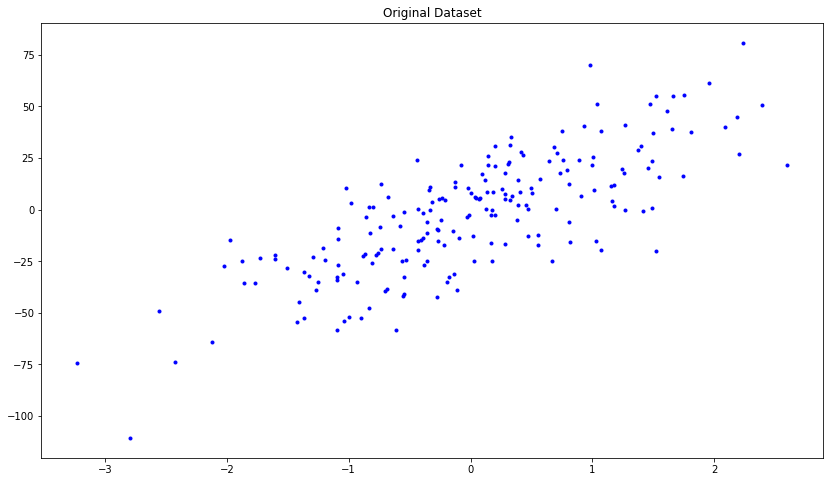

In [8]:
plt.figure(figsize=(14,8))
plt.plot(X,y,'b.')
plt.title('Original Dataset')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = skms.train_test_split(
    X, y, test_size=.4, random_state=123)

In [10]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]
print(num_outputs,num_inputs)


1 1


In [11]:
x_tensor = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(
    dtype=tf.float32, shape=[None, num_outputs], name='y')

print(x_tensor)
print(y_tensor)

Tensor("x:0", shape=(?, 1), dtype=float32)
Tensor("y:0", shape=(?, 1), dtype=float32)


x_tensor is defined as having a shape of variable rows and num_inputs columns and the number of columns is only one in our example 

y_tensor is defined as having a shape of variable rows and num_outputs columns and the number of columns is only one in our example 


In [12]:
w = tf.Variable(tf.zeros([num_inputs, num_outputs]), dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]), dtype=tf.float32, name='b')

print(w)
print(b)

<tf.Variable 'w:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'b:0' shape=(1,) dtype=float32_ref>



w is defined as a variable of dimensions num_inputs x num_outputs, which is 1 x 1 in our example 

b is defined as a variable of dimension num_outputs, which is one in our example


In [13]:
model = tf.matmul(x_tensor, w) + b

In [14]:
loss = tf.reduce_mean(tf.square(model - y_tensor))
mse = tf.reduce_mean(tf.square(model - y_tensor))


model - y_tensor calculates the residuals 

tf.square( model - y_tensor) calculates the squares of each residual 

tf.reduce_mean( ... ) finally calculates the mean of squares calculated in the preceding step



We also define the r-squared (rs) function to evaluate the trained model.


In [15]:
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [16]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

TensorFlow offers many other optimizer functions such as Adadelta, Adagrad, and Adam.

In [17]:
num_epochs = 1500
w_hat = 0
b_hat = 0
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0
rs_score = 0


In [18]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    #After initializing the session and the global variables, run the training loop for num_epoch times:
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        
        #Within each iteration of the loop, run the optimizer on the training data:
        #Using the learned w and b values, calculate the error and save it in loss_val to plot it later:
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        #Calculate the mean squared error and r-squared value for the predicted values of the test data:
        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

    #Finally, once the loop is finished, save the values of w and b to plot them later:
    w_hat, b_hat = tfs.run([w, b])
    w_hat = w_hat.reshape(1)

#Let's print the model and final mean squared error on the test data        
print('model : Y = {0:.8f} X + {1:.8f}'.format(w_hat[0], b_hat[0]))
print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(mse_score, rs_score))

model : Y = 20.37448120 X + -2.75295639
For test data : MSE = 297.57992554, R2 = 0.66098368 


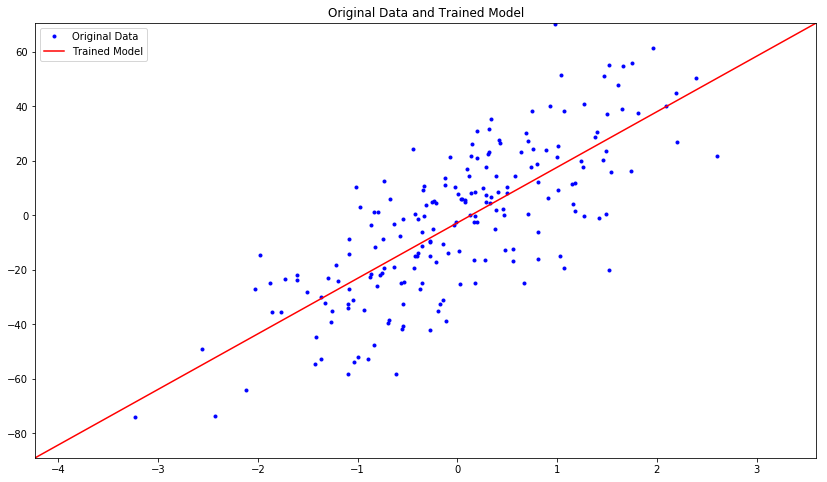

In [19]:
plt.figure(figsize=(14, 8))
plt.title('Original Data and Trained Model')

x_plot = [np.min(X) - 1, np.max(X) + 1]
y_plot = w_hat * x_plot + b_hat
plt.axis([x_plot[0], x_plot[1], y_plot[0], y_plot[1]])
plt.plot(X, y, 'b.', label='Original Data')
plt.plot(x_plot, y_plot, 'r-', label='Trained Model')
plt.legend()
plt.show()

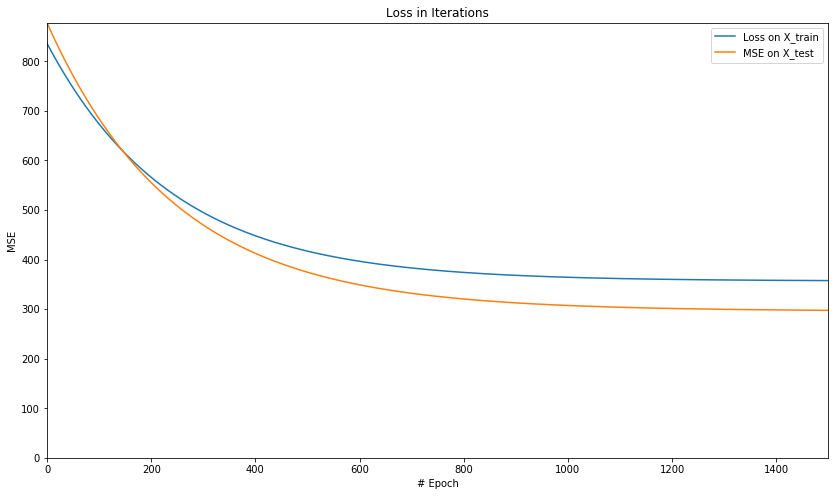

In [20]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

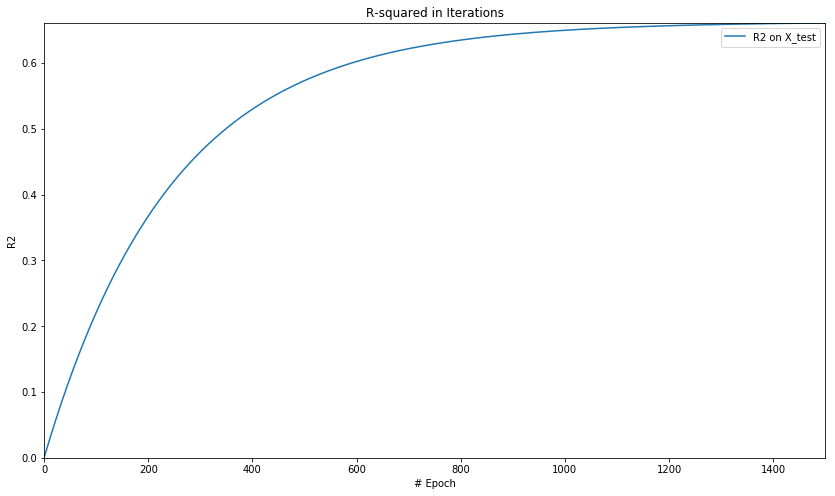

In [21]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

# Boston Dataset

In [22]:
boston=skds.load_boston()
print(boston.DESCR)

X=boston.data.astype(np.float32)
y=boston.target.astype(np.float32)
if (y.ndim == 1):
    y = y.reshape(-1,1)
X = skpp.StandardScaler().fit_transform(X)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [23]:
X_train, X_test, y_train, y_test = skms.train_test_split(
    X, y, test_size=.4, random_state=123)
print(X_train.shape)

(303, 13)


In [24]:
print(y_train.shape)

(303, 1)


# Simple Multi Regression

In [25]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(
    dtype=tf.float32, shape=[None, num_outputs], name='y')



In [26]:
w = tf.Variable(
    tf.zeros([num_inputs, num_outputs]), dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]), dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

In [27]:
print(w.shape,b.shape)

(13, 1) (1,)


In [28]:
loss = tf.reduce_mean(tf.square(model - y_tensor))
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [29]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [30]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0


In [31]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.48501968, R2 = 0.64172244 


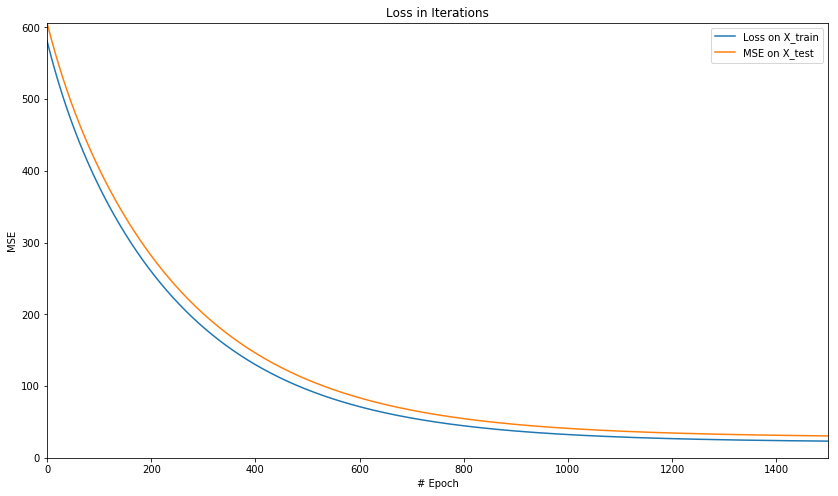

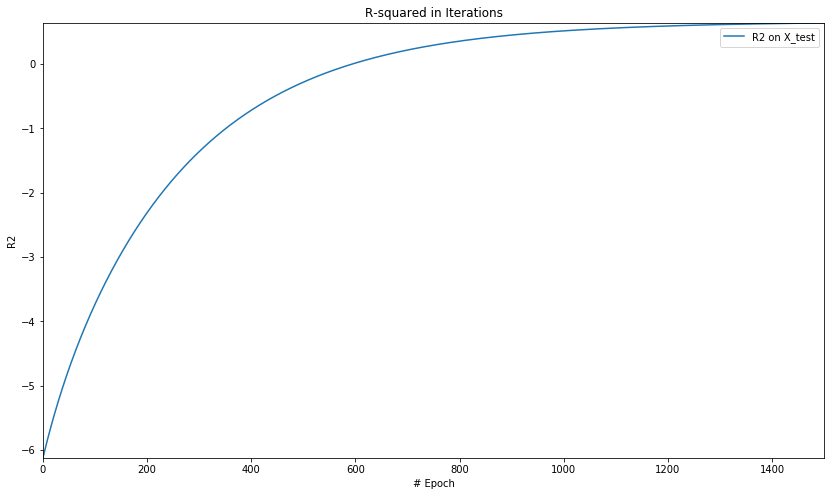

In [32]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

# Regularization

## Lasso Regularlization

In [33]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]


In [34]:
print(num_outputs,num_inputs)

1 13


In [35]:
x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')


In [36]:
w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

In [37]:
print(w.shape,b.shape)

(13, 1) (1,)


In [38]:
#lasso_param = tf.Variable(0.8, dtype=tf.float32)
lasso_param = tf.constant(0.8, dtype=tf.float32)
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + lasso_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


In [39]:
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [40]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0


In [41]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val,_ = tfs.run([loss,optimizer], feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score,rs_score = tfs.run([mse,rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.69847298, R2 = 0.63921380 


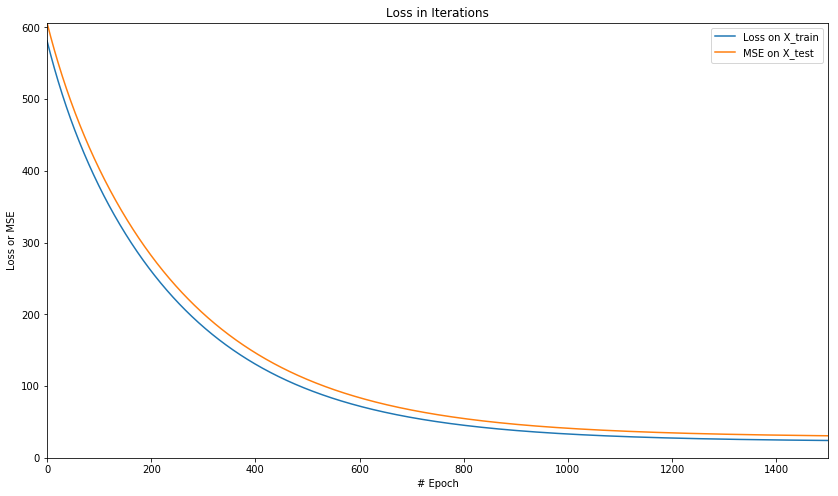

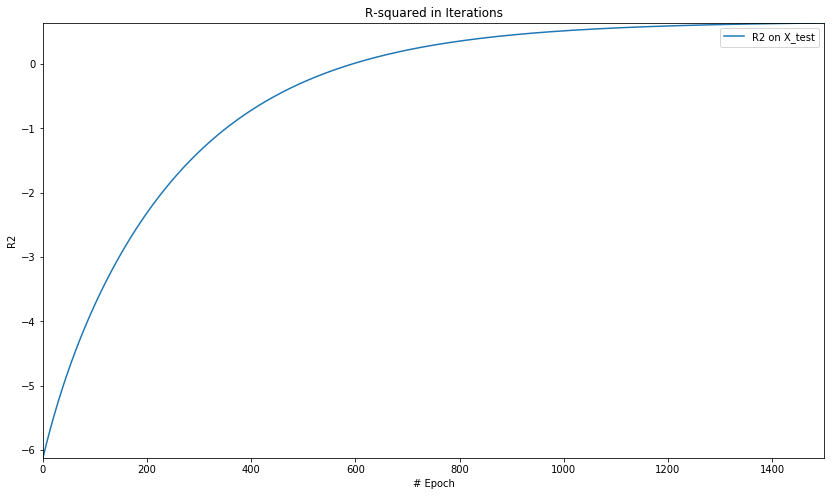

In [42]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

## Ridge Regularization

In [43]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

In [44]:
x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')


In [45]:
w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

In [46]:
#ridge_param = tf.Variable(0.8, dtype=tf.float32)
ridge_param = tf.constant(0.8, dtype=tf.float32)
ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + ridge_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


In [47]:
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [48]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0


In [49]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score
        
print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.38316345, R2 = 0.64291954 


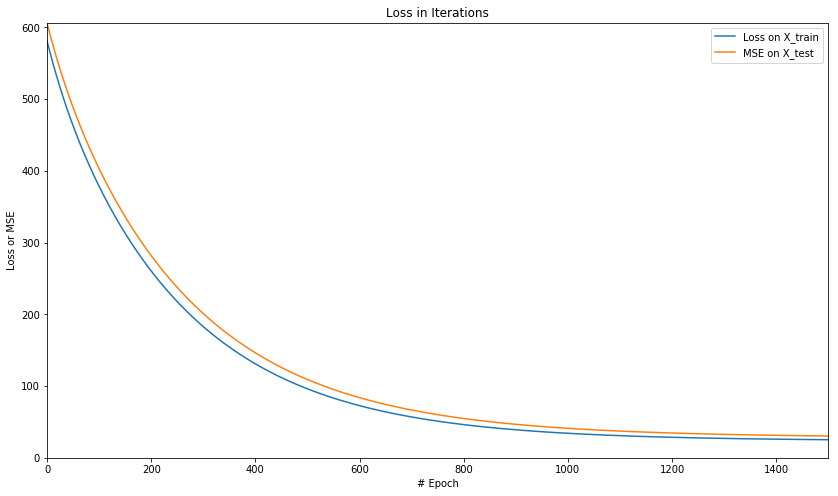

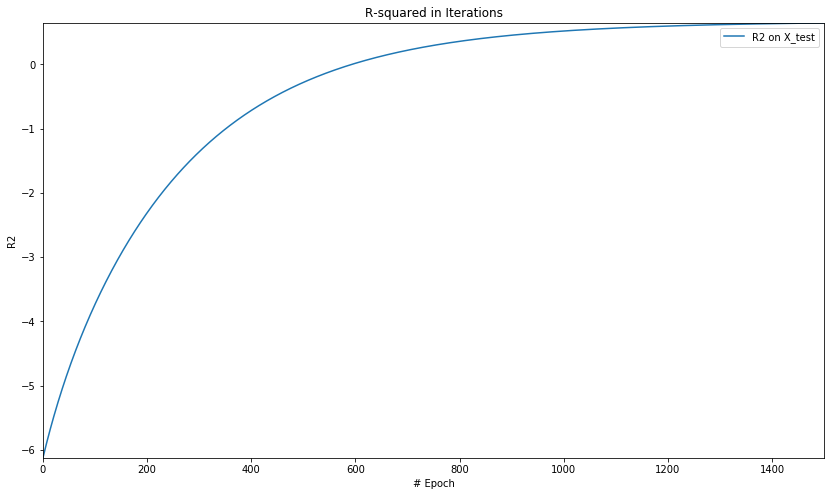

In [50]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

## ElasticNet Regularization

In [51]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

In [52]:
x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')

In [53]:
w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

In [54]:
#ridge_param = tf.Variable(0.8, dtype=tf.float32)
#ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param
ridge_loss = tf.reduce_mean(tf.square(w)) * 0.8
lasso_param = tf.Variable(0.8, dtype=tf.float32)
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + \
    ridge_loss + lasso_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [55]:
# mse and R2 functions
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [56]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0


In [57]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.38647652, R2 = 0.64288056 


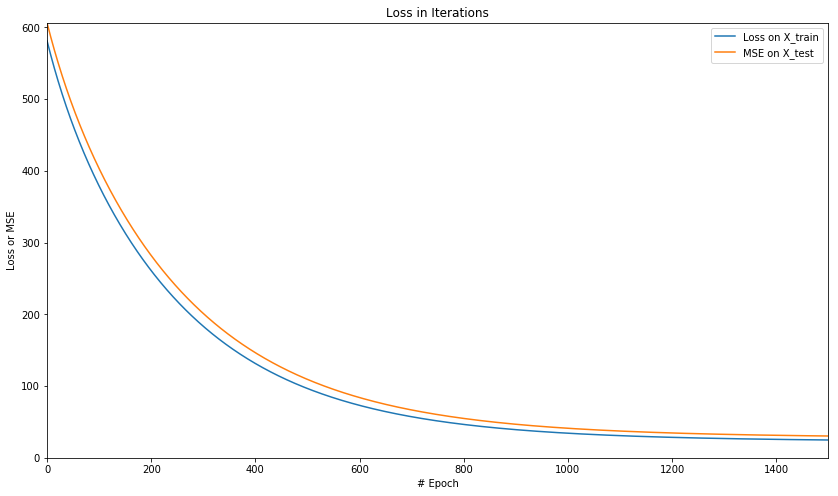

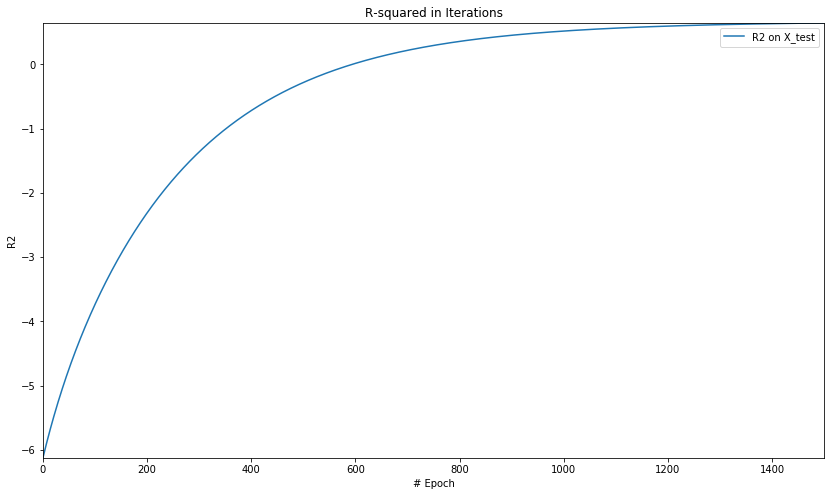

In [58]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()